# 1. Introduction:

This Jupyter Notebook performs exploratory data analysis and feature engineering on a fraud detection. The goal is to identify patterns and relationships within the data that might be useful for building a machine learning model to predict fraudulent transactions.

# 2. Libraries:

pandas: Used for data manipulation and analysis.
numpy: Used for numerical computations.
matplotlib.pyplot: Used for creating visualizations like histograms and boxplots.
seaborn: Used for creating advanced statistical plots like heatmaps.
scikit-learn: Used for data preprocessing, model selection, and evaluation.
xgboost: Used for XGBoost classifier (if available).
lightgbm: Used for LightGBM classifier.

# 3. Data Loading and Exploration:

The code loads the  dataset using pandas.read_csv.
Basic information about the data (shape, data types) is obtained using df.info().
Descriptive statistics (mean, standard deviation, etc.) for all columns are calculated using df.describe(include="all").
The number of missing values in each column is checked with df.isnull().sum().
The number of unique values in each column is printed using a loop.
The unique values in the target variable (isFlaggedFraud) are displayed.

# 4. Data Cleaning:

Rows containing missing values in specific columns (newbalanceDest, isFraud, isFlaggedFraud) are dropped using df.dropna(subset=columns_to_check).
The resulting DataFrame is checked for remaining missing values with df.isnull().sum().

# 5. Exploratory Data Analysis (EDA):

Histograms are created for all numerical columns using df.hist() to visualize data distribution.
A boxplot is created for the step column using plt.boxplot() to explore potential outliers.


# 6. Feature Engineering:

Handling Categorical Columns:

A new DataFrame (data_encoded) is created using pd.get_dummies() to encode categorical columns (e.g., "type") into one-hot encoded features.
Boolean values in the encoded DataFrame are converted to numeric (1 for True, 0 for False) using data_encoded.replace().
Correlation Matrix:

Numeric columns are selected using data_encoded.select_dtypes().
A correlation matrix is calculated using data_encoded[numeric_columns].corr() and visualized as a heatmap using sns.heatmap(). This helps identify highly correlated features.
Multicollinearity Check:

VIF (Variance Inflation Factor) is calculated for each numeric feature using statsmodels.stats.outliers_influence.variance_inflation_factor.
A DataFrame (vif_data) is created to store feature names and VIF values.
Features with high VIF (> 5, depending on the dataset) might indicate multicollinearity and can be considered for removal or combination.
Combining Correlated Features:

Based on the VIF analysis, the code identifies that oldbalanceOrg and newbalanceOrig are highly correlated.
A new feature named balance_change_orig is created by subtracting newbalanceOrig from oldbalanceOrg. This represents the change in balance at the origin.
The original columns (oldbalanceOrg and newbalanceOrig) are dropped.
Similarly, a new feature balance_change_dest is created for the destination balance change.
The original oldbalanceDest and newbalanceDest columns are dropped.

# 7. Data Preprocessing:

Categorical columns (nameOrig and nameDest) are dropped as they might not be suitable for scaling.

Features (X) and the target variable (y) are separated using X = data_encoded.drop('isFraud', axis=1) and y = data_encoded['isFraud'].

The data is split into training and testing sets using train_test_split for model evaluation.

Scaling:

A StandardScaler object is created and fitted on the training features (X_train).
The training and testing features are scaled using the fitted scaler (scaler.transform).

# 8. Model Training and Evaluation:

A list of machine learning models is defined, including:
Logistic Regression
Decision Tree
Random Forest
Gradient Boosting (XGB)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
df=pd.read_csv("/content/Fraud.csv")

In [4]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14247 entries, 0 to 14246
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            14247 non-null  int64  
 1   type            14247 non-null  object 
 2   amount          14247 non-null  float64
 3   nameOrig        14247 non-null  object 
 4   oldbalanceOrg   14246 non-null  float64
 5   newbalanceOrig  14246 non-null  float64
 6   nameDest        14246 non-null  object 
 7   oldbalanceDest  14246 non-null  float64
 8   newbalanceDest  14246 non-null  float64
 9   isFraud         14246 non-null  float64
 10  isFlaggedFraud  14246 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.2+ MB


In [6]:
df.describe(include="all")

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,14247.000000,14247,1.424700e+04,14247,1.424600e+04,1.424600e+04,14246,1.424600e+04,1.424600e+04,14246.000000,14246.0
unique,NaN,5,NaN,14247,NaN,NaN,9472,NaN,NaN,NaN,NaN
top,NaN,PAYMENT,NaN,C1231006815,NaN,NaN,C985934102,NaN,NaN,NaN,NaN
freq,NaN,7869,NaN,1,NaN,NaN,64,NaN,NaN,NaN,NaN
mean,5.037131,NaN,1.118848e+05,NaN,7.937369e+05,8.107136e+05,NaN,8.411336e+05,1.147629e+06,0.005475,0.0
std,2.463112,NaN,2.805152e+05,NaN,2.016693e+06,2.059984e+06,NaN,2.528174e+06,3.151706e+06,0.073794,0.0
min,1.000000,NaN,2.390000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000,0.0
25%,2.000000,NaN,4.585130e+03,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000,0.0
50%,6.000000,NaN,1.286936e+04,NaN,2.041500e+04,8.216325e+03,NaN,0.000000e+00,0.000000e+00,0.000000,0.0
75%,7.000000,NaN,1.218917e+05,NaN,1.384956e+05,1.294173e+05,NaN,2.641427e+05,2.775150e+05,0.000000,0.0


In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

In [8]:
for i in df.columns:
  print(f"Unique values in column {i}: {df[i].nunique()}")

Unique values in column step: 8
Unique values in column type: 5
Unique values in column amount: 14185
Unique values in column nameOrig: 14247
Unique values in column oldbalanceOrg: 10099
Unique values in column newbalanceOrig: 8127
Unique values in column nameDest: 9472
Unique values in column oldbalanceDest: 6081
Unique values in column newbalanceDest: 2244
Unique values in column isFraud: 2
Unique values in column isFlaggedFraud: 1


In [9]:
df['isFlaggedFraud'].unique()

array([ 0., nan])

In [10]:
# Define a list of columns to check for missing values
columns_to_check = ['newbalanceDest', 'isFraud','isFlaggedFraud']

# Drop rows with missing values in the specified columns
df = df.dropna(subset=columns_to_check)

# checking the resulting DataFrame
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

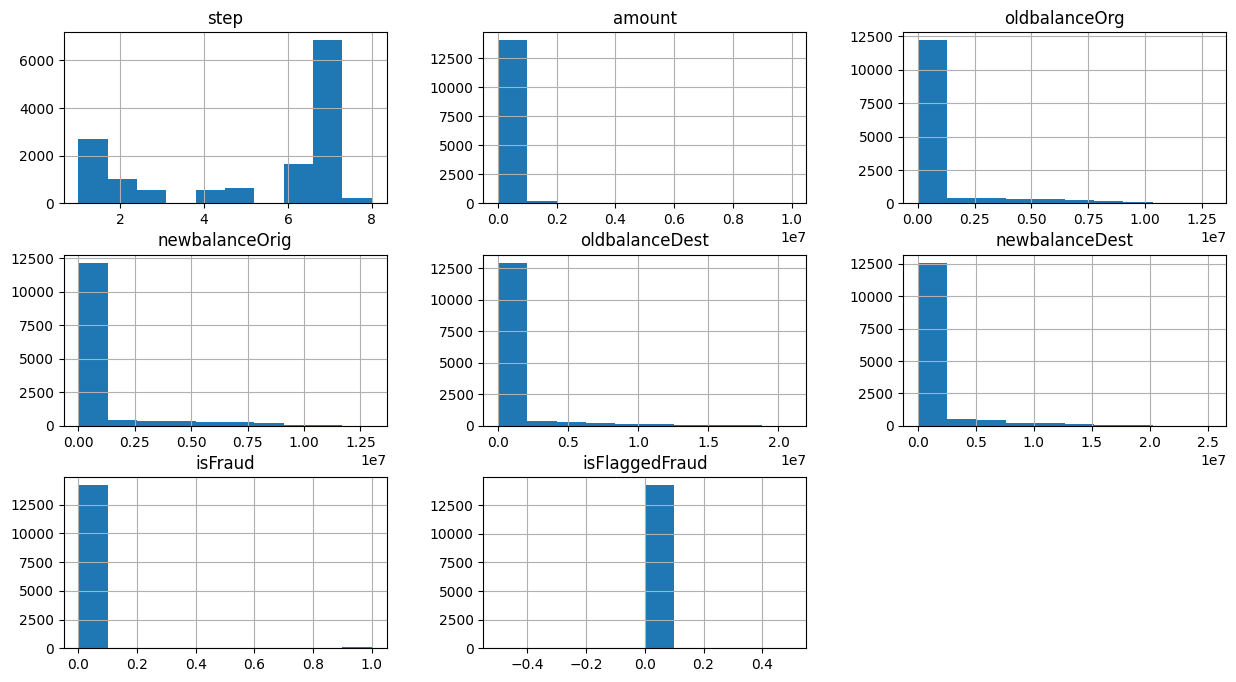

In [11]:
df.hist(figsize=(15,8))
plt.show()

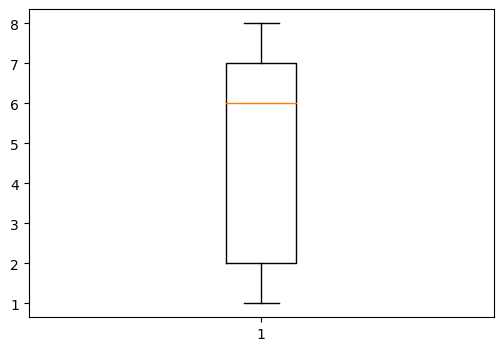

In [12]:
plt.figure(figsize=(6,4))
plt.boxplot(df['step'])
plt.show()

In [13]:
#making type column numeric for co-relation matrix
data_encoded=pd.get_dummies(df,columns=["type"])
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14246 entries, 0 to 14245
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            14246 non-null  int64  
 1   amount          14246 non-null  float64
 2   nameOrig        14246 non-null  object 
 3   oldbalanceOrg   14246 non-null  float64
 4   newbalanceOrig  14246 non-null  float64
 5   nameDest        14246 non-null  object 
 6   oldbalanceDest  14246 non-null  float64
 7   newbalanceDest  14246 non-null  float64
 8   isFraud         14246 non-null  float64
 9   isFlaggedFraud  14246 non-null  float64
 10  type_CASH_IN    14246 non-null  bool   
 11  type_CASH_OUT   14246 non-null  bool   
 12  type_DEBIT      14246 non-null  bool   
 13  type_PAYMENT    14246 non-null  bool   
 14  type_TRANSFER   14246 non-null  bool   
dtypes: bool(5), float64(7), int64(1), object(2)
memory usage: 1.3+ MB


In [14]:
#changing bool values to numeric
data_encoded=data_encoded.replace(({True: 1, False: 0}))


In [15]:
# Select only numeric columns for correlation matrix
numeric_columns = data_encoded.select_dtypes(include=['float64', 'int64',]).columns
print(numeric_columns)
correlation_matrix = data_encoded[numeric_columns].corr()



Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


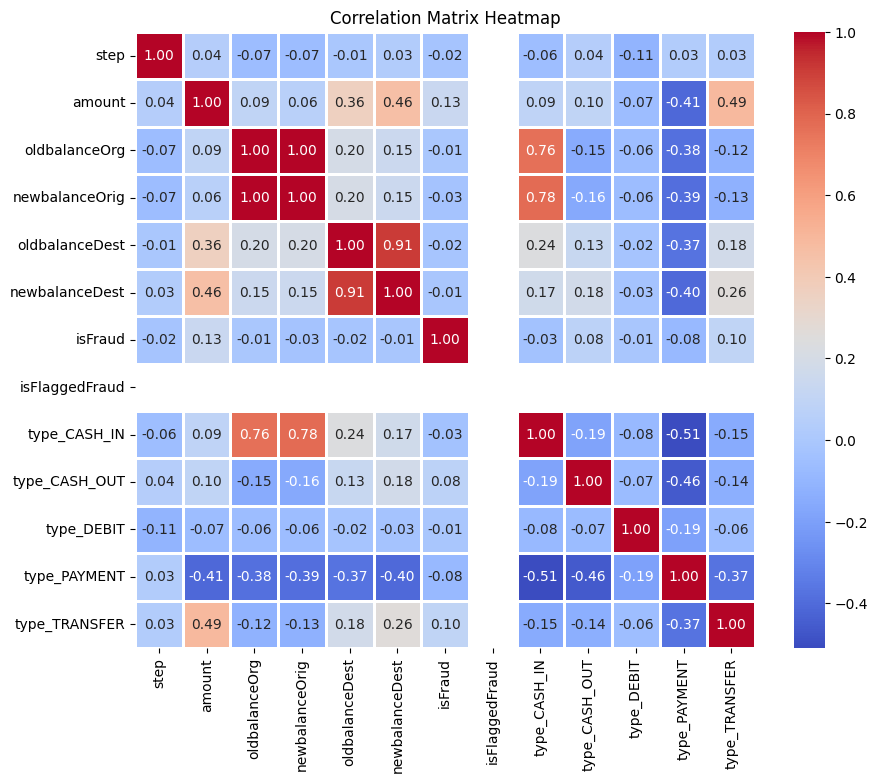

In [16]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.8)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [17]:
#checking multicoliniarty by VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Select only numeric columns for VIF calculation
numeric_columns = data_encoded.select_dtypes(include=['number']).columns
X = data_encoded[numeric_columns].drop(['isFraud', 'isFlaggedFraud'], axis=1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

           Feature         VIF
0             step    1.025662
1           amount    2.127497
2    oldbalanceOrg  217.314083
3   newbalanceOrig  231.773663
4   oldbalanceDest    6.166458
5   newbalanceDest    6.766988
6     type_CASH_IN    4.244266
7    type_CASH_OUT    1.799924
8       type_DEBIT    1.060498
9     type_PAYMENT    3.446419
10   type_TRANSFER    2.017296


We see that oldbalanceOrg and newbalanceOrig are highly co-related.We need to remove one of these 2 columns or combine the columns and mekr new one

In [18]:
#combine oldbalanceOrg and newbalanceOrig  columns and meke new one

# Creating a new feature 'balance_change' as the difference between oldbalanceOrg and newbalanceOrig

data_encoded['balance_change_orig'] = data_encoded['oldbalanceOrg'] - data_encoded['newbalanceOrig']

# Drop the original columns if no longer needed
data_encoded = data_encoded.drop(columns=['oldbalanceOrg', 'newbalanceOrig'])

# Creating a new feature by the difference between oldbalanceDest and newbalanceDest

data_encoded['balance_change_dest'] = data_encoded['oldbalanceDest'] - data_encoded['newbalanceDest']

# Drop the original columns if no longer needed
data_encoded = data_encoded.drop(columns=['oldbalanceDest', 'newbalanceDest'])


In [19]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14246 entries, 0 to 14245
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   step                 14246 non-null  int64  
 1   amount               14246 non-null  float64
 2   nameOrig             14246 non-null  object 
 3   nameDest             14246 non-null  object 
 4   isFraud              14246 non-null  float64
 5   isFlaggedFraud       14246 non-null  float64
 6   type_CASH_IN         14246 non-null  int64  
 7   type_CASH_OUT        14246 non-null  int64  
 8   type_DEBIT           14246 non-null  int64  
 9   type_PAYMENT         14246 non-null  int64  
 10  type_TRANSFER        14246 non-null  int64  
 11  balance_change_orig  14246 non-null  float64
 12  balance_change_dest  14246 non-null  float64
dtypes: float64(5), int64(6), object(2)
memory usage: 1.5+ MB


In [20]:
# Select only numeric columns for VIF calculation
numeric_columns = data_encoded.select_dtypes(include=['number']).columns
X = data_encoded[numeric_columns].drop(['isFraud', 'isFlaggedFraud'], axis=1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

               Feature       VIF
0                 step  1.023986
1               amount  1.959471
2         type_CASH_IN  2.130181
3        type_CASH_OUT  1.762414
4           type_DEBIT  1.058566
5         type_PAYMENT  3.433843
6        type_TRANSFER  2.010045
7  balance_change_orig  1.501340
8  balance_change_dest  1.246713


In [21]:
#removing categorical columns for further scaling process
data_encoded = data_encoded.drop(columns=['nameOrig', 'nameDest'])

In [22]:
# Separate features (X) and target variable (y)
X = data_encoded.drop('isFraud', axis=1)  # Drop the target variable from features
y = data_encoded['isFraud']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Create a StandardScaler object
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training features (X_train)
scaler.fit(X_train)

# Transform (scale) the training and testing features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
models=[
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting (XGBoost)", GradientBoostingClassifier())
    ]

In [25]:
# Train and evaluate each model
for name, model in models:
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"{name} Accuracy:", accuracy)

Logistic Regression Accuracy: 0.9936842105263158
Decision Tree Accuracy: 0.9940350877192983
Random Forest Accuracy: 0.9950877192982456
Gradient Boosting (XGBoost) Accuracy: 0.9950877192982456


# Thank you